# Product Demand Forecast

In [33]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product 

from time import time
from datetime import timedelta
from tqdm.notebook import tqdm

In [27]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))

## Explore data

### Read input data

In [2]:
orig_demand_df = pd.read_csv('Historical Product Demand.csv')
print('Original: ' + str(orig_demand_df.shape))
orig_demand_df.head(4)

Original: (1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500


### Data preprocessing

Use more compact and consistent column names

In [3]:
demand_df = orig_demand_df.copy()
demand_df.columns = ['ID', 'Warehouse', 'Category', 'Date', 'Demand']

Then, Let's check for NAs

In [4]:
demand_df.isna().sum()

ID               0
Warehouse        0
Category         0
Date         11239
Demand           0
dtype: int64

As we can see, only date column has NAs. Since we literally have no way to figure out the missing date, we need to drop all of them.

In [5]:
# remove NA
demand_df.dropna(inplace=True)
print('After: ' + str(demand_df.shape))

After: (1037336, 5)


In [6]:
# convert demand to int
demand_df.Demand = demand_df.Demand.str.replace('\(|\)', '').astype(int)
# convert to datetime
demand_df.Date = pd.to_datetime(demand_df.Date)

In [7]:
# Remove redundant prefixes
demand_df.ID = [cat.split('_')[1] for cat in demand_df.ID]
demand_df.Category = [cat.split('_')[1] for cat in demand_df.Category]

convert the data to daily

In [8]:
daily_demand_df = demand_df.groupby(['ID', 'Date', 'Category']).sum()
daily_demand_df = daily_demand_df.reset_index().sort_values(['Date', 'ID'])
daily_demand_df

,ID,Date,Category,Demand
232656,0965,2011-01-08,006,2
484830,1724,2011-05-31,003,108
436505,1521,2011-06-24,019,92000
429489,1507,2011-09-02,019,1250
151560,0608,2011-09-27,001,5
...,...,...,...,...
533387,1954,2017-01-06,001,3
538289,1970,2017-01-06,005,4000
75607,0250,2017-01-09,007,148
130234,0471,2017-01-09,015,30


A little summary for our data

In [9]:
def get_date_range(df, debugging=False):
    dates = df.Date if 'Date' in df.columns else df.index
    date_range = (dates.min(), dates.max())
    if debugging:
        print('({} - {})'.format(*date_range))
    return date_range

In [10]:
print('Date range: ')
date_range = get_date_range(daily_demand_df, debugging=True)
daily_demand_df.drop('Date', axis=1).describe(include='all').iloc[:4,:]

Date range: 
(2011-01-08 00:00:00 - 2017-01-09 00:00:00)


,ID,Category,Demand
count,582504,582504,582504.0
unique,2160,33,NaN
top,0349,019,NaN
freq,1295,205646,NaN


### Generic plots

In [11]:
sns.set(rc={'figure.figsize':(15, 8)})

In [12]:
# # sns.lineplot(data=demand_df, x='Date', y='Order_Demand', hue='Product_Category')

# cumsum_demand_df = demand_df.sort_values('Date')
# cumsum_demand_df['cumsum'] = cumsum_demand_df.groupby('Product_Category').cumsum()

# sns.lineplot(data=cumsum_demand_df, x='Date', y='cumsum', hue='Product_Category')

# del cumsum_demand_df

In [13]:
# demand_by_cat_df = demand_df.groupby('Product_Category').sum().reset_index()
# sns.set_style("whitegrid")
# g = sns.barplot(data=demand_by_cat_df, y='Order_Demand', x='Product_Category')
# g.set_yscale("log")
# del demand_by_cat_df, g

In [14]:
# g = sns.boxplot(data=demand_df, y='Order_Demand', x='Product_Category', showfliers=True)
# g.set_yscale("log")
# del g

In [15]:
# g = sns.boxplot(data=demand_df, y='Order_Demand', x='Warehouse', showfliers=True)
# g.set_yscale("log")
# del g

### Split dataset

In [16]:
train_df, test_df = train_test_split(daily_demand_df, test_size=0.1)
print('Train: {}'.format(train_df.shape))
print('Test : {}'.format(test_df.shape))

Train: (524253, 4)
Test : (58251, 4)


## ARIMA

### Check for stationarity

In [17]:
# simple function to filter dataframe with given parameters
def filter_demand(df, ID=None, category=None, Demand=-1):
    df = df.copy()
    if ID is not None:
        df = df[df.ID == ID]
    if category is not None:
        df = df[df.category == category]
    if Demand > -1:
        df = df[df.Demand > Demand]
    return df

In [18]:
def is_stationary(df, print_stats=False):
    result = adfuller(df)
    if print_stats:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
    return result[1] < 0.001

Check stationarity of 100 items with highest frequency

In [19]:
n = 100
check_ids = daily_demand_df.ID.value_counts().index[:n]
not_stationary = []
for check_id in tqdm(check_ids):
    df = filter_demand(daily_demand_df, ID=str(check_id)).Demand
    if not is_stationary(df):
        not_stationary.append(check_id)
print('{}/{} are not stationary'.format(len(not_stationary), n))


1/100 are not stationary


Only one of them is not stationary. Let's write a simple function to apply differencing.

In [20]:
import warnings
def apply_differencing(df, periods=1, ffill=False, stationary_check=True):
    if isinstance(df, pd.DataFrame) and 'Demand' in df.columns:
        df.Demand = df.Demand.diff(periods=periods)
    else:
        df = df.diff(periods=periods)
    df = df.ffill() if ffill else df.dropna()
        
    if stationary_check and not is_stationary(df.Demand if isinstance(df, pd.DataFrame) else df):
        warnings.warn('DataFrame is still not stationary.')
    return df

In [21]:
not_stationary = []
for check_id in tqdm(check_ids):
    df = filter_demand(daily_demand_df, ID=str(check_id)).Demand
    if not is_stationary(apply_differencing(df)):
        not_stationary.append(check_id)
print('{}/{} are not stationary'.format(len(not_stationary), n))


0/100 are not stationary


Okay, now we have the function, we only need to call it when we build the model.

### Finding right parameters

In [22]:
train_date_range = get_date_range(train_df, debugging=True)

(2011-05-31 00:00:00 - 2017-01-09 00:00:00)


In [23]:
def get_train_data(df, date_range=None, differencing=0):
    df = df.drop(columns=['ID', 'Category'])
    df = df.set_index('Date')
    
    # fill date gap
    if date_range is not None:
        idx = pd.date_range(*date_range)
        df = df.reindex(idx, fill_value=0)
        
    if differencing > 0:
        df = apply_differencing(df, periods=differencing)
    
    return df

In [24]:
highest_freq_item_df = filter_demand(train_df, ID=str(check_ids[0]))
item_df = get_train_data(highest_freq_item_df, train_date_range)
item_diff_df = get_train_data(highest_freq_item_df, train_date_range, differencing=True)
del highest_freq_item_df

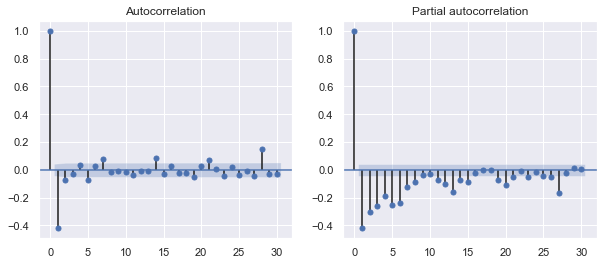

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
lags = 30
sm.graphics.tsa.plot_acf(item_diff_df, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(item_diff_df, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

It's 

In [40]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def_range = range(0,4)
@ignore_warnings(category=ConvergenceWarning)
def optimize_SARIMA(df, p_range=def_range, d=1, q_range=def_range, \
                    P_range=def_range, D=1, Q_range=def_range, s_range=def_range):   
    results = []
    best_aic = float('inf')
    
    params = list(product(p_range, q_range, P_range, Q_range, s_range))
    for param in tqdm(params):
        try: model = SARIMAX(df, order=(param[0], d, param[1]),
                             seasonal_order=(param[2], D, param[3], param[4])).fit(disp=-1)
        except: continue
        if model.aic < best_aic:
            best_model = model
            best_aic = model.aic
            best_param = param
        results.append([param, model.aic])
        
    results = pd.DataFrame(results, columns=['param', 'aic']).sort_values('aic')
    return results.reset_index(drop=True)

In [37]:
start_time = time()
d = 1
D = 0
tried_models = optimize_SARIMA(item_df, d=d, D=D)
print_elapsed_time(start_time)

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: Co

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: Co

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



Elapsed time: 0:11:03


In [45]:
tried_models[:5]

,param,aic
0,"(1, 0, 1, 2, 2)",10.000000
1,"(1, 0, 3, 2, 2)",14.000000
2,"(3, 1, 0, 2, 2)",32.589464
3,"(0, 1, 2, 3, 2)",27246.174731
4,"(0, 1, 3, 2, 2)",27253.205221


So, we have the params for our SARIMA model now

In [47]:
best_model = tried_models.param[0]
order = (best_model[0], d, best_model[1])
seasonal_order = (best_model[2], D, best_model[3], best_model[4])

### Build SARIMA model

In [ ]:
train_ratio = 0.1
train_df, test_df = train_test_split(daily_demand_df, test_size=0.1)
print('Train: {}'.format(train_df.shape))
print('Test : {}'.format(test_df.shape))